In [5]:
%load_ext autoreload
%autoreload 2
# import torch; torch.manual_seed(955)
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from dataGen import Gen, FastGen, Gen2
from Encoders import LongShort_TCVAE_Encoder, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
from utils import * #train_on_effect, generate_data, extract_parameters, suppress_prints, add_mu_std
from train import *
from disentangelement import *
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pprint
torch.set_printoptions(sci_mode=False)

# all parameters for generating the time series should be configured in this cell
        
p=2       
args = GENV(n_channels=4,
            latent_dims=30,
            n_samples=100,
            shuffle=False,
            periode=p,
            L=288*p,
            min_max=True,
            num_layers=4,
            ß=3,
            modified=True,
            first_kernel=288)
effects = {
    "Pulse": {
        "occurances":1,
        "max_amplitude":5,   
        "interval":40,
        "start":None
        },
    "Trend": {
        "occurances":10,
        "max_slope":0.02,
        "type":"linear",
        "start":None
        },
    "Seasonality": {
        "occurances":10,
        "frequency_per_week":(10, 20), # min and max occurances per week
        "amplitude_range":(50, 70),
        "start":-5
        },
    "Std_variation": {
        "occurances":0,
        "max_value":10,
        "interval":100,
        "start":None
        },
    "channels_coupling":{
        "occurances":0,
        "coupling_strengh":20
        },
    "Noise": {
        "occurances":0,
        "max_slope":0.005,
        "type":"linear"
        }
    }

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
vae, vq, X, args, labels, train_data, val_data, test_data, train_labels = load_all(3)

label


In [6]:
from importlib import reload
from Encoders import LongShort_TCVAE_Encoder#, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder#, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
args.num_embed = 512# args.enc_out**2 
args.robust = False
vae = Variational_Autoencoder(args,
                            v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                            v_decoder = LongShort_TCVAE_Decoder #MST_VAE_Decoder,
                           )
vq = VQ_MST_VAE(args,
                v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                v_decoder = LongShort_TCVAE_Decoder, #MST_VAE_Decoder,
                v_quantizer = VQ_Quantizer) #10 5

vae = vae.to(args.device)
vq = vq.to(args.device)

opt_vae = optim.Adam(vae.parameters(), lr = 0.002043529186448577) # 0.005043529186448577 0.006819850049647945
opt_vq = optim.Adam(vq.parameters(), lr = 0.002043529186448577) # 0.005043529186448577 0.006819850049647945

generating:  1
generating:  2
generating:  3
generating:  4
generating:  5
generating:  6
generating:  7
generating:  8
generating:  9


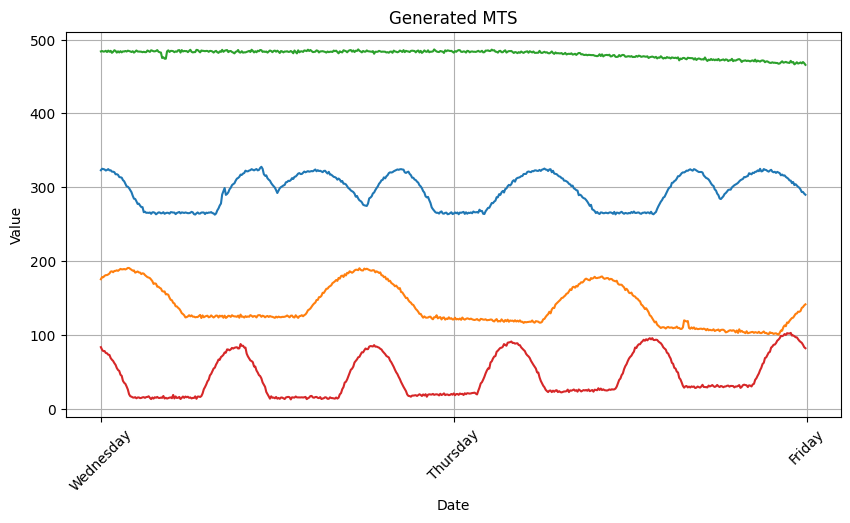

In [7]:
train_data, val_data, test_data, X = generate_labeled_data(args,
                                                           effects,
                                                           effect="both",
                                                           occurance=4,
                                                           return_gen=True,
                                                           anomalies=True,
                                                           show=args.n_channels)

In [5]:
args.min_max= True
np.set_printoptions(suppress=True)
# VAE_losses = []
# VQ_losses = []
args.robust= False

for epoch in range(1, 10000):
#     for i in range(len(vaes)):
    loss_vae = train(vae, train_data_long, args, opt_vae, epoch)
    loss_vq = train(vq, train_data_long, args, opt_vq, epoch)
    
    if epoch%100 == 1:
        display.clear_output(wait=True)
        show_results_long(vae, train_data_long, args)
        show_results_long(vq, train_data_long, args, vq=True)
        
#     VAE_losses.append(loss_vae)
#     VQ_losses.append(loss_vq)
                
    print('====> VAE: Sample {} Average loss: {:.4f}'.format(epoch, loss_vae / len(train_data_long.dataset)))
    print('====> VQ: Sample {} Average loss: {:.4f}'.format(epoch, loss_vq / len(train_data_long.dataset)))

NameError: name 'train_data_long' is not defined

In [277]:
Origin_norm_long, REC_norm_long, _ = rebuild_TS_non_overlapping(vae, train_data_long, args, keep_norm=False)
denoised_rec_long = denoise_data(REC_norm_long.T.cpu())
denoised_orig_long = denoise_data(Origin_norm_long.T.cpu())
train_data_long_denoised = DataLoader(StridedWindow(torch.from_numpy(denoised_orig_long), args),  # slidingWindow, stridedWindow
                            batch_size=args.bs,  # 59, # 22
                            shuffle=False,
                            drop_last=False
                            )

In [8]:
x, params, e_params = X.parameters()
frs = e_params["Seasonality"]["frequency_per_week"]
arr = np.array(frs)
Origin_vae_norm, REC_vae_norm, _ = rebuild_TS(vae, train_data, args, keep_norm=True)
Origin_vae, REC_vae, z = rebuild_TS(vae, train_data, args, keep_norm=False)

Origin_vq_norm, REC_vq_norm, _ = rebuild_TS(vq, train_data, args, keep_norm=True)
Origin_vq, REC_vq, indices = rebuild_TS(vq, train_data, args, keep_norm=False)
# indices = indices.mean(axis=-1).type(torch.int32)

labels = extract_parameters(args, e_params=e_params, effects=effects)
# labels = add_mu_std(labels, params)
train_labels = labels[:Origin_vae_norm.shape[0]]
                      
denoised_rec = denoise_data(REC_vae_norm.cpu())
denoised_orig = denoise_data(Origin_vae_norm.cpu())
train_data_denoised = DataLoader(NoWindow(torch.from_numpy(denoised_orig), args, train_labels, norm=True),  # slidingWindow, stridedWindow
                            batch_size=args.bs,  # 59, # 22
                            shuffle=False,
                            drop_last=False
                            )

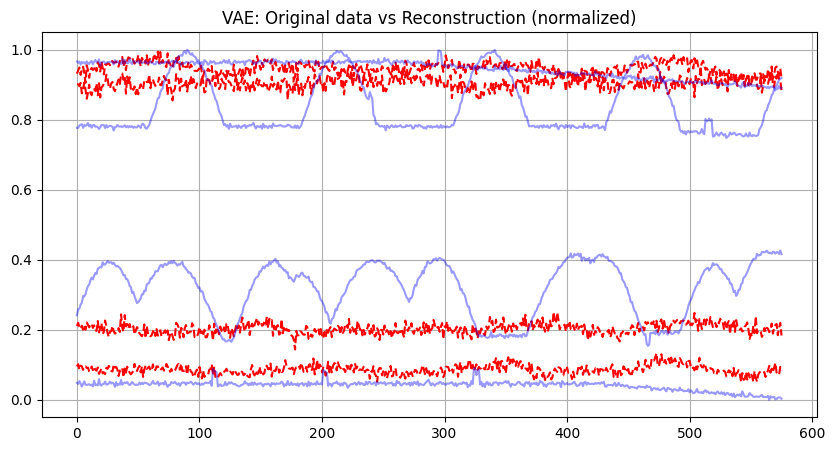

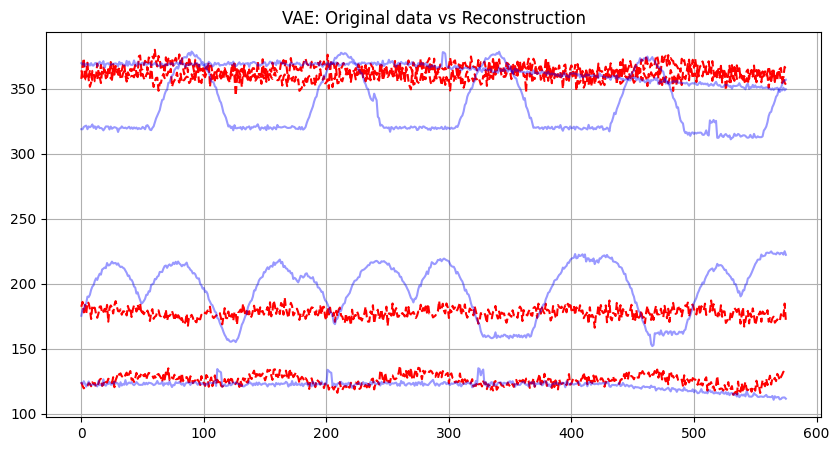

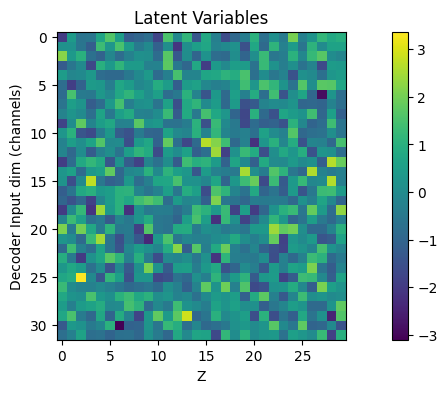

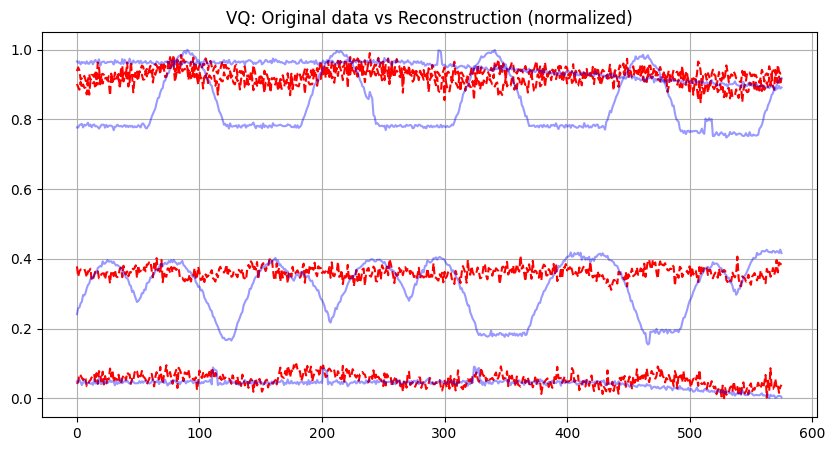

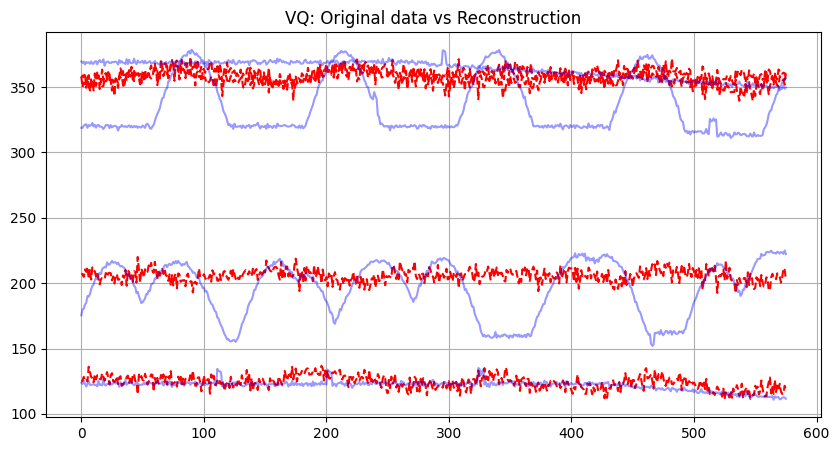

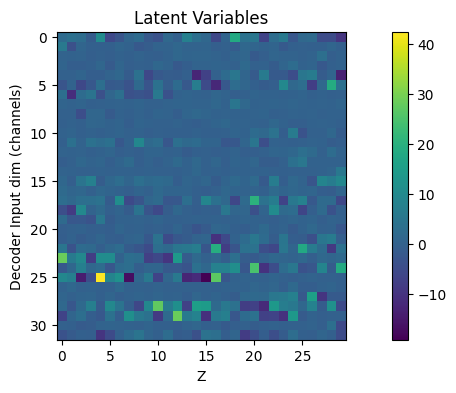

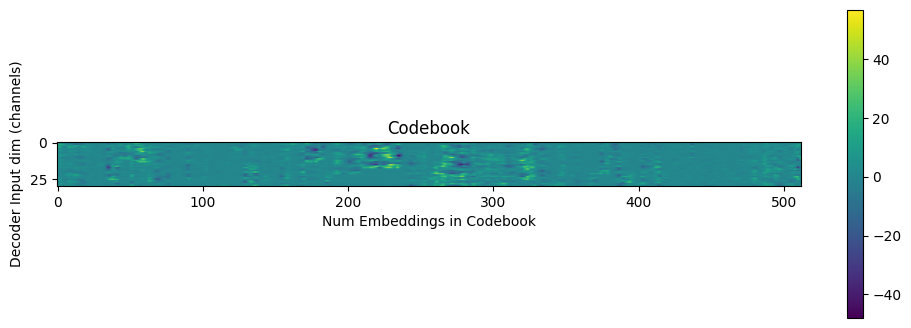

====> VAE: Sample 401 Average loss: 0.0542
====> VQ: Sample 401 Average loss: 0.0240
Train Epoch: 402 [0/4 (0%)]	Loss: 43.164455	 True Loss: 11050.100586
Train Epoch: 402 [0/4 (0%)]	Loss: 18.115868	 True Loss: 4637.662109
====> VAE: Sample 402 Average loss: 0.0546
====> VQ: Sample 402 Average loss: 0.0236
Train Epoch: 403 [0/4 (0%)]	Loss: 43.234154	 True Loss: 11067.943359
Train Epoch: 403 [0/4 (0%)]	Loss: 19.192883	 True Loss: 4913.377930
====> VAE: Sample 403 Average loss: 0.0543
====> VQ: Sample 403 Average loss: 0.0237
Train Epoch: 404 [0/4 (0%)]	Loss: 44.726215	 True Loss: 11449.911133
Train Epoch: 404 [0/4 (0%)]	Loss: 18.634769	 True Loss: 4770.500977
====> VAE: Sample 404 Average loss: 0.0561
====> VQ: Sample 404 Average loss: 0.0237
Train Epoch: 405 [0/4 (0%)]	Loss: 44.216560	 True Loss: 11319.439453
Train Epoch: 405 [0/4 (0%)]	Loss: 18.321653	 True Loss: 4690.343262
====> VAE: Sample 405 Average loss: 0.0539
====> VQ: Sample 405 Average loss: 0.0231
Train Epoch: 406 [0/4 (0%)]

Train Epoch: 439 [0/4 (0%)]	Loss: 39.301434	 True Loss: 10061.166992
Train Epoch: 439 [0/4 (0%)]	Loss: 17.824133	 True Loss: 4562.978027
====> VAE: Sample 439 Average loss: 0.0510
====> VQ: Sample 439 Average loss: 0.0225
Train Epoch: 440 [0/4 (0%)]	Loss: 41.555405	 True Loss: 10638.183594
Train Epoch: 440 [0/4 (0%)]	Loss: 18.618805	 True Loss: 4766.414062
====> VAE: Sample 440 Average loss: 0.0517
====> VQ: Sample 440 Average loss: 0.0231
Train Epoch: 441 [0/4 (0%)]	Loss: 40.541389	 True Loss: 10378.595703
Train Epoch: 441 [0/4 (0%)]	Loss: 18.063995	 True Loss: 4624.382812
====> VAE: Sample 441 Average loss: 0.0511
====> VQ: Sample 441 Average loss: 0.0225
Train Epoch: 442 [0/4 (0%)]	Loss: 42.406357	 True Loss: 10856.027344
Train Epoch: 442 [0/4 (0%)]	Loss: 17.385654	 True Loss: 4450.727539
====> VAE: Sample 442 Average loss: 0.0522
====> VQ: Sample 442 Average loss: 0.0223
Train Epoch: 443 [0/4 (0%)]	Loss: 41.354076	 True Loss: 10586.643555
Train Epoch: 443 [0/4 (0%)]	Loss: 18.352303

Train Epoch: 476 [0/4 (0%)]	Loss: 38.304642	 True Loss: 9805.988281
Train Epoch: 476 [0/4 (0%)]	Loss: 20.224377	 True Loss: 5177.440430
====> VAE: Sample 476 Average loss: 0.0488
====> VQ: Sample 476 Average loss: 0.0262
Train Epoch: 477 [0/4 (0%)]	Loss: 37.585640	 True Loss: 9621.923828
Train Epoch: 477 [0/4 (0%)]	Loss: 19.920908	 True Loss: 5099.752441
====> VAE: Sample 477 Average loss: 0.0481
====> VQ: Sample 477 Average loss: 0.0255
Train Epoch: 478 [0/4 (0%)]	Loss: 38.292526	 True Loss: 9802.886719
Train Epoch: 478 [0/4 (0%)]	Loss: 20.593998	 True Loss: 5272.063477
====> VAE: Sample 478 Average loss: 0.0484
====> VQ: Sample 478 Average loss: 0.0251
Train Epoch: 479 [0/4 (0%)]	Loss: 37.980721	 True Loss: 9723.064453
Train Epoch: 479 [0/4 (0%)]	Loss: 20.560381	 True Loss: 5263.457520
====> VAE: Sample 479 Average loss: 0.0481
====> VQ: Sample 479 Average loss: 0.0251
Train Epoch: 480 [0/4 (0%)]	Loss: 38.337715	 True Loss: 9814.455078
Train Epoch: 480 [0/4 (0%)]	Loss: 19.382214	 Tru

In [9]:
np.set_printoptions(suppress=True)
VAE_losses = []
VQ_losses = []
args.min_max=True

for epoch in range(1, 500):
    loss_vae = train(vae, train_data, args, opt_vae, epoch)
    loss_vq = train(vq, train_data, args, opt_vq, epoch)
    
    if epoch%100 == 1:
        display.clear_output(wait=True)
        show_results(vae, train_data, args, plot_latent=False)
        show_results(vq, train_data, args, vq=True, plot_latent=False)
        
    VAE_losses.append(loss_vae)
    VQ_losses.append(loss_vq)
        
    print('====> VAE: Sample {} Average loss: {:.4f}'.format(epoch, loss_vae / len(train_data.dataset)))
    print('====> VQ: Sample {} Average loss: {:.4f}'.format(epoch, loss_vq / len(train_data.dataset)))

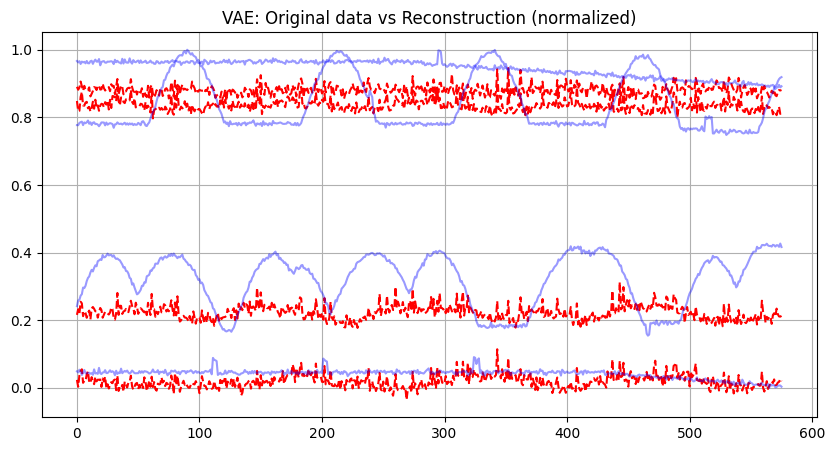

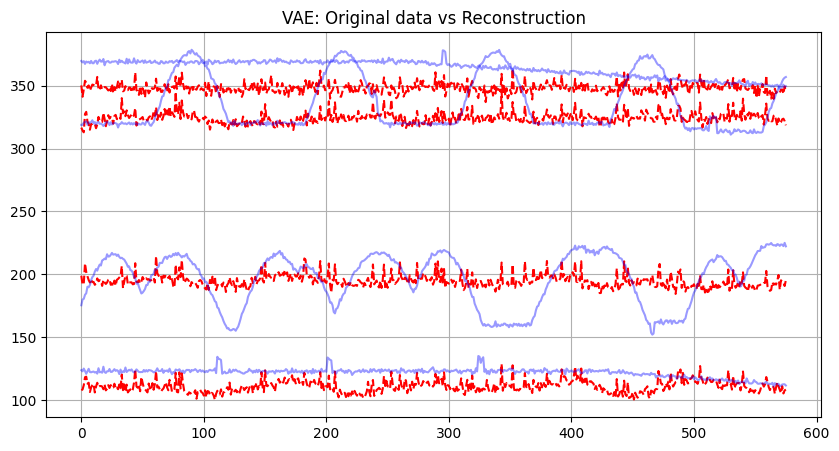

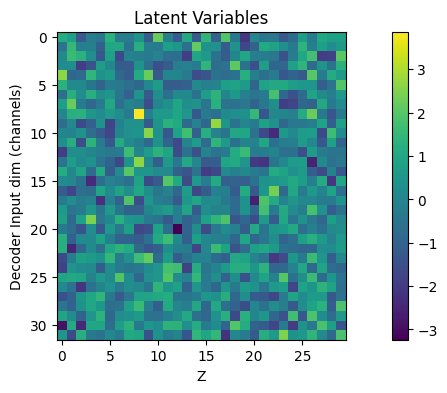

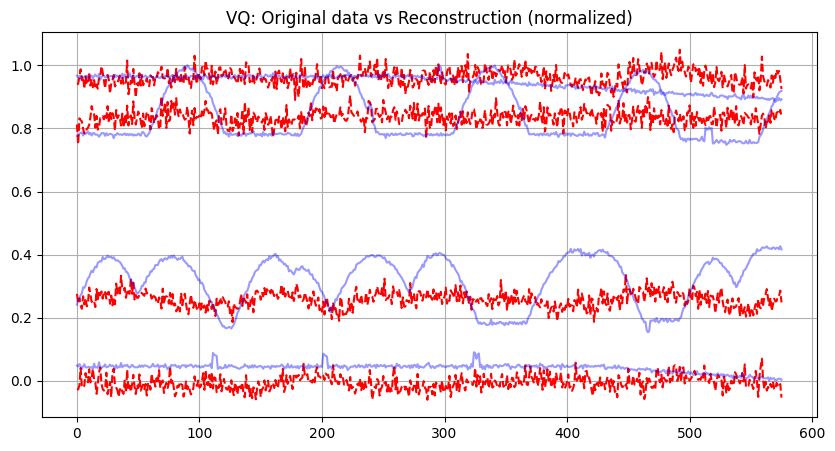

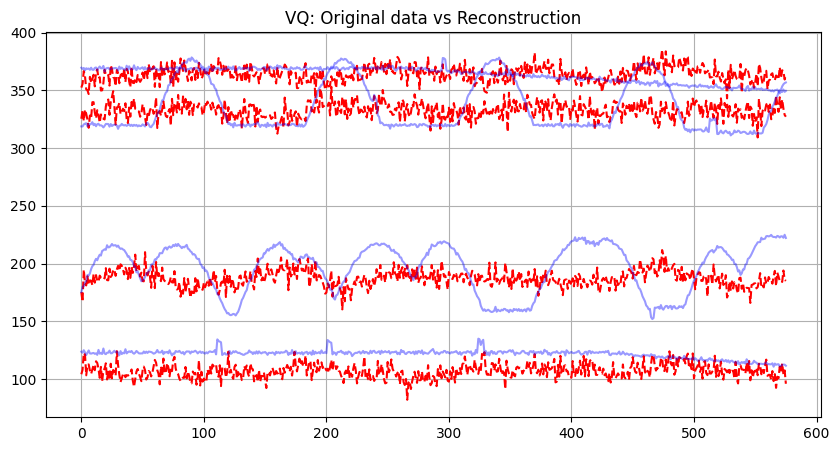

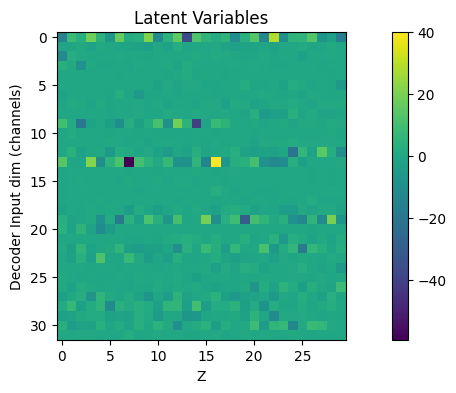

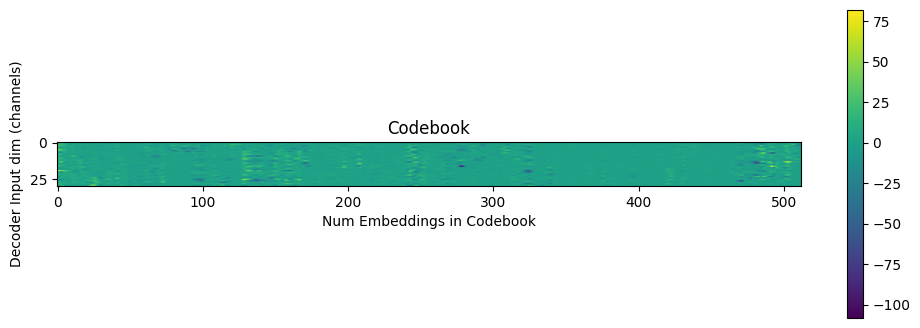

In [4]:
show_results(vae, train_data, args, plot_latent=False)
show_results(vq, train_data, args, vq=True, plot_latent=False)

Train Epoch: 1 [0/800 (0%)]	Loss: 3.112700
====> Epoch: 1 Average loss: 3.9904
True Loss:  3192.2858276367188
Train Epoch: 2 [0/800 (0%)]	Loss: 3.109735
====> Epoch: 2 Average loss: 3.9883
True Loss:  3190.67333984375
Train Epoch: 3 [0/800 (0%)]	Loss: 3.105031
====> Epoch: 3 Average loss: 3.9794
True Loss:  3183.5320434570312
Train Epoch: 4 [0/800 (0%)]	Loss: 3.100141
====> Epoch: 4 Average loss: 3.9749
True Loss:  3179.9129028320312
Train Epoch: 5 [0/800 (0%)]	Loss: 3.094652
====> Epoch: 5 Average loss: 3.9681
True Loss:  3174.5123901367188
Train Epoch: 6 [0/800 (0%)]	Loss: 3.090252
====> Epoch: 6 Average loss: 3.9613
True Loss:  3169.0458984375
Train Epoch: 7 [0/800 (0%)]	Loss: 3.085192
====> Epoch: 7 Average loss: 3.9550
True Loss:  3163.9924926757812
Train Epoch: 8 [0/800 (0%)]	Loss: 3.081011
====> Epoch: 8 Average loss: 3.9487
True Loss:  3158.95654296875
Train Epoch: 9 [0/800 (0%)]	Loss: 3.075243
====> Epoch: 9 Average loss: 3.9423
True Loss:  3153.8523559570312


/home/kadran1/git/lab/disentangelement.py:387: RuntimeWarning: divide by zero encountered in log
  max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))


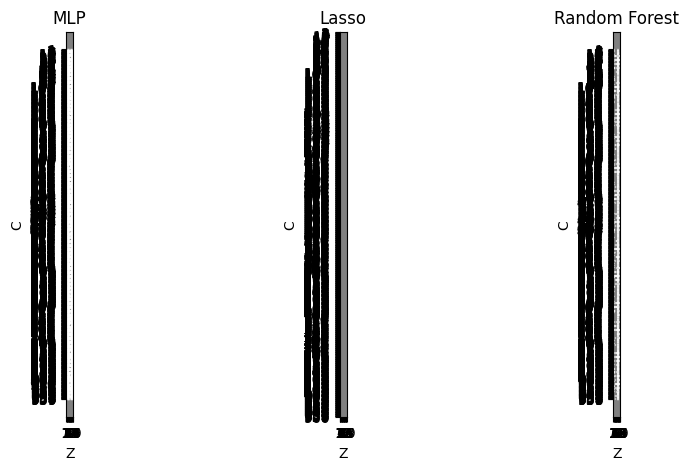

In [165]:
dis = DIS(vae, X, effects, args, train_data, epochs=10)

In [249]:
cp= CP(vae, vq,  X, args, labels=labels, t)
cp.save_all()

1


In [10]:
save_all(vae, vq, X, args, train_data, val_data, test_data, labels=labels, train_labels=train_labels)

3


In [297]:
from disentangelement import identifier
id_mlp_vae = identifier(args=args, n_layers=1, output_size=labels.shape[-1])
id_mlp_vq = identifier(args=args, n_layers=1, output_size=labels.shape[-1])

id_mlp_vae = id_mlp_vae.to(args.device)
id_mlp_vq = id_mlp_vq.to(args.device)

id_mlp_vae_opt = optim.Adam(id_mlp_vae.parameters(), lr = 0.01)
id_mlp_vq_opt = optim.Adam(id_mlp_vq.parameters(), lr = 0.01)

In [298]:
id_mlp_vae = id_mlp_vae.to(args.device)
id_mlp_vq = id_mlp_vq.to(args.device)
for epoch in range(1,1000):
    y_train_pred_mlp_vae = train_identifier_modified(vae, id_mlp_vae,train_data, id_mlp_vae_opt, args, epoch)
    y_train_pred_mlp_vq = train_identifier_modified(vq, id_mlp_vq,train_data, id_mlp_vq_opt, args, epoch)
id_mlp_vae = id_mlp_vae.to("cpu")
id_mlp_vq = id_mlp_vq.to("cpu")

Train Epoch: 1 [0/4000 (0%)]	Loss: 7.269686
====> Epoch: 1 Average loss: 7.3931
True Loss:  29572.324584960938
Train Epoch: 1 [0/4000 (0%)]	Loss: 7.268529
====> Epoch: 1 Average loss: 7.3921
True Loss:  29568.589111328125
Train Epoch: 2 [0/4000 (0%)]	Loss: 7.224346
====> Epoch: 2 Average loss: 7.3464
True Loss:  29385.438232421875
Train Epoch: 2 [0/4000 (0%)]	Loss: 7.223731
====> Epoch: 2 Average loss: 7.3467
True Loss:  29386.662719726562
Train Epoch: 3 [0/4000 (0%)]	Loss: 7.179763
====> Epoch: 3 Average loss: 7.3007
True Loss:  29202.77783203125
Train Epoch: 3 [0/4000 (0%)]	Loss: 7.179175
====> Epoch: 3 Average loss: 7.3015
True Loss:  29205.810302734375
Train Epoch: 4 [0/4000 (0%)]	Loss: 7.134543
====> Epoch: 4 Average loss: 7.2554
True Loss:  29021.544799804688
Train Epoch: 4 [0/4000 (0%)]	Loss: 7.134900
====> Epoch: 4 Average loss: 7.2565
True Loss:  29026.120483398438
Train Epoch: 5 [0/4000 (0%)]	Loss: 7.090920
====> Epoch: 5 Average loss: 7.2107
True Loss:  28842.81298828125
Tra

====> Epoch: 37 Average loss: 5.9278
True Loss:  23711.127807617188
Train Epoch: 38 [0/4000 (0%)]	Loss: 5.787940
====> Epoch: 38 Average loss: 5.8896
True Loss:  23558.54150390625
Train Epoch: 38 [0/4000 (0%)]	Loss: 5.789831
====> Epoch: 38 Average loss: 5.8917
True Loss:  23566.859008789062
Train Epoch: 39 [0/4000 (0%)]	Loss: 5.752590
====> Epoch: 39 Average loss: 5.8536
True Loss:  23414.2197265625
Train Epoch: 39 [0/4000 (0%)]	Loss: 5.754515
====> Epoch: 39 Average loss: 5.8559
True Loss:  23423.47509765625
Train Epoch: 40 [0/4000 (0%)]	Loss: 5.717462
====> Epoch: 40 Average loss: 5.8182
True Loss:  23272.876831054688
Train Epoch: 40 [0/4000 (0%)]	Loss: 5.719416
====> Epoch: 40 Average loss: 5.8202
True Loss:  23280.96630859375
Train Epoch: 41 [0/4000 (0%)]	Loss: 5.682958
====> Epoch: 41 Average loss: 5.7829
True Loss:  23131.55517578125
Train Epoch: 41 [0/4000 (0%)]	Loss: 5.684531
====> Epoch: 41 Average loss: 5.7848
True Loss:  23139.326049804688
Train Epoch: 42 [0/4000 (0%)]	Loss

====> Epoch: 74 Average loss: 4.7231
True Loss:  18892.479248046875
Train Epoch: 74 [0/4000 (0%)]	Loss: 4.641323
====> Epoch: 74 Average loss: 4.7253
True Loss:  18901.173950195312
Train Epoch: 75 [0/4000 (0%)]	Loss: 4.611073
====> Epoch: 75 Average loss: 4.6939
True Loss:  18775.492553710938
Train Epoch: 75 [0/4000 (0%)]	Loss: 4.612634
====> Epoch: 75 Average loss: 4.6961
True Loss:  18784.533447265625
Train Epoch: 76 [0/4000 (0%)]	Loss: 4.581906
====> Epoch: 76 Average loss: 4.6649
True Loss:  18659.65576171875
Train Epoch: 76 [0/4000 (0%)]	Loss: 4.584098
====> Epoch: 76 Average loss: 4.6671
True Loss:  18668.508544921875
Train Epoch: 77 [0/4000 (0%)]	Loss: 4.554163
====> Epoch: 77 Average loss: 4.6362
True Loss:  18544.615234375
Train Epoch: 77 [0/4000 (0%)]	Loss: 4.555713
====> Epoch: 77 Average loss: 4.6383
True Loss:  18553.0927734375
Train Epoch: 78 [0/4000 (0%)]	Loss: 4.525374
====> Epoch: 78 Average loss: 4.6072
True Loss:  18428.8515625
Train Epoch: 78 [0/4000 (0%)]	Loss: 4.5

====> Epoch: 110 Average loss: 3.7634
True Loss:  15053.425109863281
Train Epoch: 111 [0/4000 (0%)]	Loss: 3.669888
====> Epoch: 111 Average loss: 3.7369
True Loss:  14947.721496582031
Train Epoch: 111 [0/4000 (0%)]	Loss: 3.671835
====> Epoch: 111 Average loss: 3.7390
True Loss:  14955.859741210938
Train Epoch: 112 [0/4000 (0%)]	Loss: 3.645788
====> Epoch: 112 Average loss: 3.7125
True Loss:  14849.964050292969
Train Epoch: 112 [0/4000 (0%)]	Loss: 3.647998
====> Epoch: 112 Average loss: 3.7147
True Loss:  14858.753234863281
Train Epoch: 113 [0/4000 (0%)]	Loss: 3.621824
====> Epoch: 113 Average loss: 3.6883
True Loss:  14753.152038574219
Train Epoch: 113 [0/4000 (0%)]	Loss: 3.624274
====> Epoch: 113 Average loss: 3.6905
True Loss:  14762.099731445312
Train Epoch: 114 [0/4000 (0%)]	Loss: 3.598936
====> Epoch: 114 Average loss: 3.6646
True Loss:  14658.465087890625
Train Epoch: 114 [0/4000 (0%)]	Loss: 3.600660
====> Epoch: 114 Average loss: 3.6665
True Loss:  14665.891967773438
Train Epoch

====> Epoch: 146 Average loss: 2.9526
True Loss:  11810.540161132812
Train Epoch: 147 [0/4000 (0%)]	Loss: 2.877867
====> Epoch: 147 Average loss: 2.9298
True Loss:  11719.224243164062
Train Epoch: 147 [0/4000 (0%)]	Loss: 2.880057
====> Epoch: 147 Average loss: 2.9320
True Loss:  11727.925048828125
Train Epoch: 148 [0/4000 (0%)]	Loss: 2.857275
====> Epoch: 148 Average loss: 2.9094
True Loss:  11637.416748046875
Train Epoch: 148 [0/4000 (0%)]	Loss: 2.859900
====> Epoch: 148 Average loss: 2.9114
True Loss:  11645.692932128906
Train Epoch: 149 [0/4000 (0%)]	Loss: 2.837521
====> Epoch: 149 Average loss: 2.8887
True Loss:  11554.764282226562
Train Epoch: 149 [0/4000 (0%)]	Loss: 2.839837
====> Epoch: 149 Average loss: 2.8910
True Loss:  11563.844421386719
Train Epoch: 150 [0/4000 (0%)]	Loss: 2.817307
====> Epoch: 150 Average loss: 2.8685
True Loss:  11474.178344726562
Train Epoch: 150 [0/4000 (0%)]	Loss: 2.819868
====> Epoch: 150 Average loss: 2.8706
True Loss:  11482.373046875
Train Epoch: 1

====> Epoch: 182 Average loss: 2.2674
True Loss:  9069.678527832031
Train Epoch: 183 [0/4000 (0%)]	Loss: 2.208832
====> Epoch: 183 Average loss: 2.2478
True Loss:  8991.014953613281
Train Epoch: 183 [0/4000 (0%)]	Loss: 2.211596
====> Epoch: 183 Average loss: 2.2500
True Loss:  9000.169738769531
Train Epoch: 184 [0/4000 (0%)]	Loss: 2.191873
====> Epoch: 184 Average loss: 2.2308
True Loss:  8923.336364746094
Train Epoch: 184 [0/4000 (0%)]	Loss: 2.194650
====> Epoch: 184 Average loss: 2.2328
True Loss:  8931.01025390625
Train Epoch: 185 [0/4000 (0%)]	Loss: 2.175849
====> Epoch: 185 Average loss: 2.2133
True Loss:  8853.15771484375
Train Epoch: 185 [0/4000 (0%)]	Loss: 2.177789
====> Epoch: 185 Average loss: 2.2155
True Loss:  8862.195983886719
Train Epoch: 186 [0/4000 (0%)]	Loss: 2.158418
====> Epoch: 186 Average loss: 2.1964
True Loss:  8785.721069335938
Train Epoch: 186 [0/4000 (0%)]	Loss: 2.161013
====> Epoch: 186 Average loss: 2.1984
True Loss:  8793.726745605469
Train Epoch: 187 [0/40

====> Epoch: 218 Average loss: 1.6950
True Loss:  6780.084197998047
Train Epoch: 219 [0/4000 (0%)]	Loss: 1.651664
====> Epoch: 219 Average loss: 1.6787
True Loss:  6714.6514892578125
Train Epoch: 219 [0/4000 (0%)]	Loss: 1.653479
====> Epoch: 219 Average loss: 1.6806
True Loss:  6722.556884765625
Train Epoch: 220 [0/4000 (0%)]	Loss: 1.637626
====> Epoch: 220 Average loss: 1.6644
True Loss:  6657.433258056641
Train Epoch: 220 [0/4000 (0%)]	Loss: 1.639458
====> Epoch: 220 Average loss: 1.6663
True Loss:  6665.347961425781
Train Epoch: 221 [0/4000 (0%)]	Loss: 1.622761
====> Epoch: 221 Average loss: 1.6500
True Loss:  6600.162078857422
Train Epoch: 221 [0/4000 (0%)]	Loss: 1.625514
====> Epoch: 221 Average loss: 1.6521
True Loss:  6608.453063964844
Train Epoch: 222 [0/4000 (0%)]	Loss: 1.608621
====> Epoch: 222 Average loss: 1.6357
True Loss:  6542.902801513672
Train Epoch: 222 [0/4000 (0%)]	Loss: 1.611647
====> Epoch: 222 Average loss: 1.6380
True Loss:  6551.876159667969
Train Epoch: 223 [0

====> Epoch: 254 Average loss: 1.2261
True Loss:  4904.520965576172
Train Epoch: 255 [0/4000 (0%)]	Loss: 1.193806
====> Epoch: 255 Average loss: 1.2124
True Loss:  4849.673095703125
Train Epoch: 255 [0/4000 (0%)]	Loss: 1.196388
====> Epoch: 255 Average loss: 1.2145
True Loss:  4858.002258300781
Train Epoch: 256 [0/4000 (0%)]	Loss: 1.184450
====> Epoch: 256 Average loss: 1.2009
True Loss:  4803.751281738281
Train Epoch: 256 [0/4000 (0%)]	Loss: 1.185053
====> Epoch: 256 Average loss: 1.2029
True Loss:  4811.774810791016
Train Epoch: 257 [0/4000 (0%)]	Loss: 1.171761
====> Epoch: 257 Average loss: 1.1895
True Loss:  4757.810455322266
Train Epoch: 257 [0/4000 (0%)]	Loss: 1.173788
====> Epoch: 257 Average loss: 1.1915
True Loss:  4765.840087890625
Train Epoch: 258 [0/4000 (0%)]	Loss: 1.160524
====> Epoch: 258 Average loss: 1.1777
True Loss:  4710.787628173828
Train Epoch: 258 [0/4000 (0%)]	Loss: 1.162595
====> Epoch: 258 Average loss: 1.1800
True Loss:  4720.197174072266
Train Epoch: 259 [0/

====> Epoch: 290 Average loss: 0.8522
True Loss:  3408.9969177246094
Train Epoch: 291 [0/4000 (0%)]	Loss: 0.829855
====> Epoch: 291 Average loss: 0.8412
True Loss:  3364.7862548828125
Train Epoch: 291 [0/4000 (0%)]	Loss: 0.831992
====> Epoch: 291 Average loss: 0.8431
True Loss:  3372.5552825927734
Train Epoch: 292 [0/4000 (0%)]	Loss: 0.820986
====> Epoch: 292 Average loss: 0.8322
True Loss:  3328.9285736083984
Train Epoch: 292 [0/4000 (0%)]	Loss: 0.823114
====> Epoch: 292 Average loss: 0.8341
True Loss:  3336.3800048828125
Train Epoch: 293 [0/4000 (0%)]	Loss: 0.812032
====> Epoch: 293 Average loss: 0.8229
True Loss:  3291.6534118652344
Train Epoch: 293 [0/4000 (0%)]	Loss: 0.814301
====> Epoch: 293 Average loss: 0.8251
True Loss:  3300.468780517578
Train Epoch: 294 [0/4000 (0%)]	Loss: 0.804002
====> Epoch: 294 Average loss: 0.8143
True Loss:  3257.043716430664
Train Epoch: 294 [0/4000 (0%)]	Loss: 0.805552
====> Epoch: 294 Average loss: 0.8162
True Loss:  3264.8215942382812
Train Epoch: 

====> Epoch: 326 Average loss: 0.5648
True Loss:  2259.3301696777344
Train Epoch: 327 [0/4000 (0%)]	Loss: 0.550140
====> Epoch: 327 Average loss: 0.5561
True Loss:  2224.4564514160156
Train Epoch: 327 [0/4000 (0%)]	Loss: 0.551941
====> Epoch: 327 Average loss: 0.5580
True Loss:  2231.9847106933594
Train Epoch: 328 [0/4000 (0%)]	Loss: 0.543752
====> Epoch: 328 Average loss: 0.5495
True Loss:  2198.1075439453125
Train Epoch: 328 [0/4000 (0%)]	Loss: 0.545281
====> Epoch: 328 Average loss: 0.5512
True Loss:  2204.8778686523438
Train Epoch: 329 [0/4000 (0%)]	Loss: 0.537160
====> Epoch: 329 Average loss: 0.5427
True Loss:  2170.689208984375
Train Epoch: 329 [0/4000 (0%)]	Loss: 0.538679
====> Epoch: 329 Average loss: 0.5445
True Loss:  2178.0076751708984
Train Epoch: 330 [0/4000 (0%)]	Loss: 0.530437
====> Epoch: 330 Average loss: 0.5358
True Loss:  2143.149673461914
Train Epoch: 330 [0/4000 (0%)]	Loss: 0.532135
====> Epoch: 330 Average loss: 0.5378
True Loss:  2151.3734130859375
Train Epoch: 

====> Epoch: 362 Average loss: 0.3547
True Loss:  1418.6342315673828
Train Epoch: 363 [0/4000 (0%)]	Loss: 0.345017
====> Epoch: 363 Average loss: 0.3477
True Loss:  1390.7056503295898
Train Epoch: 363 [0/4000 (0%)]	Loss: 0.347222
====> Epoch: 363 Average loss: 0.3498
True Loss:  1399.3032760620117
Train Epoch: 364 [0/4000 (0%)]	Loss: 0.341248
====> Epoch: 364 Average loss: 0.3431
True Loss:  1372.573875427246
Train Epoch: 364 [0/4000 (0%)]	Loss: 0.342516
====> Epoch: 364 Average loss: 0.3450
True Loss:  1380.1770248413086
Train Epoch: 365 [0/4000 (0%)]	Loss: 0.334561
====> Epoch: 365 Average loss: 0.3383
True Loss:  1353.1501922607422
Train Epoch: 365 [0/4000 (0%)]	Loss: 0.337860
====> Epoch: 365 Average loss: 0.3403
True Loss:  1361.2560424804688
Train Epoch: 366 [0/4000 (0%)]	Loss: 0.331216
====> Epoch: 366 Average loss: 0.3336
True Loss:  1334.2629852294922
Train Epoch: 366 [0/4000 (0%)]	Loss: 0.333253
====> Epoch: 366 Average loss: 0.3356
True Loss:  1342.5380020141602
Train Epoch:

====> Epoch: 398 Average loss: 0.2113
True Loss:  845.0425071716309
Train Epoch: 399 [0/4000 (0%)]	Loss: 0.205495
====> Epoch: 399 Average loss: 0.2060
True Loss:  824.1956977844238
Train Epoch: 399 [0/4000 (0%)]	Loss: 0.207601
====> Epoch: 399 Average loss: 0.2081
True Loss:  832.4729232788086
Train Epoch: 400 [0/4000 (0%)]	Loss: 0.203218
====> Epoch: 400 Average loss: 0.2029
True Loss:  811.5021896362305
Train Epoch: 400 [0/4000 (0%)]	Loss: 0.204542
====> Epoch: 400 Average loss: 0.2050
True Loss:  820.0702514648438
Train Epoch: 401 [0/4000 (0%)]	Loss: 0.200080
====> Epoch: 401 Average loss: 0.2000
True Loss:  799.9430541992188
Train Epoch: 401 [0/4000 (0%)]	Loss: 0.201524
====> Epoch: 401 Average loss: 0.2020
True Loss:  807.8353614807129
Train Epoch: 402 [0/4000 (0%)]	Loss: 0.195855
====> Epoch: 402 Average loss: 0.1968
True Loss:  787.2141075134277
Train Epoch: 402 [0/4000 (0%)]	Loss: 0.198546
====> Epoch: 402 Average loss: 0.1989
True Loss:  795.7654876708984
Train Epoch: 403 [0/

====> Epoch: 434 Average loss: 0.1225
True Loss:  490.1744956970215
Train Epoch: 435 [0/4000 (0%)]	Loss: 0.119607
====> Epoch: 435 Average loss: 0.1187
True Loss:  474.92498207092285
Train Epoch: 435 [0/4000 (0%)]	Loss: 0.121253
====> Epoch: 435 Average loss: 0.1207
True Loss:  482.9241600036621
Train Epoch: 436 [0/4000 (0%)]	Loss: 0.117904
====> Epoch: 436 Average loss: 0.1168
True Loss:  467.0762634277344
Train Epoch: 436 [0/4000 (0%)]	Loss: 0.119489
====> Epoch: 436 Average loss: 0.1189
True Loss:  475.79852867126465
Train Epoch: 437 [0/4000 (0%)]	Loss: 0.116103
====> Epoch: 437 Average loss: 0.1151
True Loss:  460.5966281890869
Train Epoch: 437 [0/4000 (0%)]	Loss: 0.117755
====> Epoch: 437 Average loss: 0.1172
True Loss:  468.79725456237793
Train Epoch: 438 [0/4000 (0%)]	Loss: 0.114736
====> Epoch: 438 Average loss: 0.1131
True Loss:  452.46018409729004
Train Epoch: 438 [0/4000 (0%)]	Loss: 0.116052
====> Epoch: 438 Average loss: 0.1155
True Loss:  461.92026138305664
Train Epoch: 43

====> Epoch: 470 Average loss: 0.0749
True Loss:  299.41046714782715
Train Epoch: 471 [0/4000 (0%)]	Loss: 0.073045
====> Epoch: 471 Average loss: 0.0717
True Loss:  286.8261432647705
Train Epoch: 471 [0/4000 (0%)]	Loss: 0.074837
====> Epoch: 471 Average loss: 0.0740
True Loss:  295.8998107910156
Train Epoch: 472 [0/4000 (0%)]	Loss: 0.072481
====> Epoch: 472 Average loss: 0.0709
True Loss:  283.78551483154297
Train Epoch: 472 [0/4000 (0%)]	Loss: 0.073983
====> Epoch: 472 Average loss: 0.0731
True Loss:  292.47023582458496
Train Epoch: 473 [0/4000 (0%)]	Loss: 0.071560
====> Epoch: 473 Average loss: 0.0705
True Loss:  282.04310417175293
Train Epoch: 473 [0/4000 (0%)]	Loss: 0.073148
====> Epoch: 473 Average loss: 0.0723
True Loss:  289.1203498840332
Train Epoch: 474 [0/4000 (0%)]	Loss: 0.070416
====> Epoch: 474 Average loss: 0.0693
True Loss:  277.2229061126709
Train Epoch: 474 [0/4000 (0%)]	Loss: 0.072332
====> Epoch: 474 Average loss: 0.0715
True Loss:  285.8493309020996
Train Epoch: 475

====> Epoch: 506 Average loss: 0.0539
True Loss:  215.78146362304688
Train Epoch: 507 [0/4000 (0%)]	Loss: 0.052296
====> Epoch: 507 Average loss: 0.0515
True Loss:  206.12798500061035
Train Epoch: 507 [0/4000 (0%)]	Loss: 0.054461
====> Epoch: 507 Average loss: 0.0536
True Loss:  214.46756172180176
Train Epoch: 508 [0/4000 (0%)]	Loss: 0.052228
====> Epoch: 508 Average loss: 0.0512
True Loss:  204.6156644821167
Train Epoch: 508 [0/4000 (0%)]	Loss: 0.054140
====> Epoch: 508 Average loss: 0.0533
True Loss:  213.19505882263184
Train Epoch: 509 [0/4000 (0%)]	Loss: 0.052179
====> Epoch: 509 Average loss: 0.0510
True Loss:  204.112154006958
Train Epoch: 509 [0/4000 (0%)]	Loss: 0.053829
====> Epoch: 509 Average loss: 0.0530
True Loss:  211.96302795410156
Train Epoch: 510 [0/4000 (0%)]	Loss: 0.051075
====> Epoch: 510 Average loss: 0.0506
True Loss:  202.5208396911621
Train Epoch: 510 [0/4000 (0%)]	Loss: 0.053528
====> Epoch: 510 Average loss: 0.0527
True Loss:  210.7705535888672
Train Epoch: 511

====> Epoch: 542 Average loss: 0.0471
True Loss:  188.47585678100586
Train Epoch: 543 [0/4000 (0%)]	Loss: 0.046570
====> Epoch: 543 Average loss: 0.0448
True Loss:  179.08314323425293
Train Epoch: 543 [0/4000 (0%)]	Loss: 0.047763
====> Epoch: 543 Average loss: 0.0470
True Loss:  188.13812446594238
Train Epoch: 544 [0/4000 (0%)]	Loss: 0.044750
====> Epoch: 544 Average loss: 0.0450
True Loss:  180.00997734069824
Train Epoch: 544 [0/4000 (0%)]	Loss: 0.047679
====> Epoch: 544 Average loss: 0.0470
True Loss:  187.81512355804443
Train Epoch: 545 [0/4000 (0%)]	Loss: 0.044682
====> Epoch: 545 Average loss: 0.0446
True Loss:  178.52269649505615
Train Epoch: 545 [0/4000 (0%)]	Loss: 0.047599
====> Epoch: 545 Average loss: 0.0469
True Loss:  187.5062837600708
Train Epoch: 546 [0/4000 (0%)]	Loss: 0.045572
====> Epoch: 546 Average loss: 0.0446
True Loss:  178.50120639801025
Train Epoch: 546 [0/4000 (0%)]	Loss: 0.047522
====> Epoch: 546 Average loss: 0.0468
True Loss:  187.21115684509277
Train Epoch:

====> Epoch: 578 Average loss: 0.0456
True Loss:  182.59992790222168
Train Epoch: 579 [0/4000 (0%)]	Loss: 0.045496
====> Epoch: 579 Average loss: 0.0436
True Loss:  174.51177597045898
Train Epoch: 579 [0/4000 (0%)]	Loss: 0.046283
====> Epoch: 579 Average loss: 0.0456
True Loss:  182.54904556274414
Train Epoch: 580 [0/4000 (0%)]	Loss: 0.044424
====> Epoch: 580 Average loss: 0.0436
True Loss:  174.43948364257812
Train Epoch: 580 [0/4000 (0%)]	Loss: 0.046270
====> Epoch: 580 Average loss: 0.0456
True Loss:  182.50120544433594
Train Epoch: 581 [0/4000 (0%)]	Loss: 0.043784
====> Epoch: 581 Average loss: 0.0435
True Loss:  174.11997985839844
Train Epoch: 581 [0/4000 (0%)]	Loss: 0.046257
====> Epoch: 581 Average loss: 0.0456
True Loss:  182.45627689361572
Train Epoch: 582 [0/4000 (0%)]	Loss: 0.044325
====> Epoch: 582 Average loss: 0.0435
True Loss:  174.01506900787354
Train Epoch: 582 [0/4000 (0%)]	Loss: 0.046245
====> Epoch: 582 Average loss: 0.0456
True Loss:  182.41408729553223
Train Epoch

====> Epoch: 614 Average loss: 0.0455
True Loss:  181.88706588745117
Train Epoch: 615 [0/4000 (0%)]	Loss: 0.044979
====> Epoch: 615 Average loss: 0.0438
True Loss:  175.27485466003418
Train Epoch: 615 [0/4000 (0%)]	Loss: 0.046083
====> Epoch: 615 Average loss: 0.0455
True Loss:  181.8834047317505
Train Epoch: 616 [0/4000 (0%)]	Loss: 0.044343
====> Epoch: 616 Average loss: 0.0435
True Loss:  174.02465724945068
Train Epoch: 616 [0/4000 (0%)]	Loss: 0.046082
====> Epoch: 616 Average loss: 0.0455
True Loss:  181.880051612854
Train Epoch: 617 [0/4000 (0%)]	Loss: 0.043418
====> Epoch: 617 Average loss: 0.0432
True Loss:  172.60163116455078
Train Epoch: 617 [0/4000 (0%)]	Loss: 0.046080
====> Epoch: 617 Average loss: 0.0455
True Loss:  181.87697315216064
Train Epoch: 618 [0/4000 (0%)]	Loss: 0.044432
====> Epoch: 618 Average loss: 0.0434
True Loss:  173.43686294555664
Train Epoch: 618 [0/4000 (0%)]	Loss: 0.046079
====> Epoch: 618 Average loss: 0.0455
True Loss:  181.8741579055786
Train Epoch: 61

====> Epoch: 650 Average loss: 0.0455
True Loss:  181.8471803665161
Train Epoch: 651 [0/4000 (0%)]	Loss: 0.044100
====> Epoch: 651 Average loss: 0.0434
True Loss:  173.66856575012207
Train Epoch: 651 [0/4000 (0%)]	Loss: 0.046065
====> Epoch: 651 Average loss: 0.0455
True Loss:  181.8470916748047
Train Epoch: 652 [0/4000 (0%)]	Loss: 0.045064
====> Epoch: 652 Average loss: 0.0434
True Loss:  173.65399837493896
Train Epoch: 652 [0/4000 (0%)]	Loss: 0.046065
====> Epoch: 652 Average loss: 0.0455
True Loss:  181.8470106124878
Train Epoch: 653 [0/4000 (0%)]	Loss: 0.044594
====> Epoch: 653 Average loss: 0.0434
True Loss:  173.47226428985596
Train Epoch: 653 [0/4000 (0%)]	Loss: 0.046065
====> Epoch: 653 Average loss: 0.0455
True Loss:  181.84693908691406
Train Epoch: 654 [0/4000 (0%)]	Loss: 0.044495
====> Epoch: 654 Average loss: 0.0433
True Loss:  173.3678503036499
Train Epoch: 654 [0/4000 (0%)]	Loss: 0.046065
====> Epoch: 654 Average loss: 0.0455
True Loss:  181.8468780517578
Train Epoch: 655

====> Epoch: 686 Average loss: 0.0455
True Loss:  181.84651470184326
Train Epoch: 687 [0/4000 (0%)]	Loss: 0.044063
====> Epoch: 687 Average loss: 0.0432
True Loss:  172.62854862213135
Train Epoch: 687 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 687 Average loss: 0.0455
True Loss:  181.8465118408203
Train Epoch: 688 [0/4000 (0%)]	Loss: 0.043985
====> Epoch: 688 Average loss: 0.0432
True Loss:  172.7049160003662
Train Epoch: 688 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 688 Average loss: 0.0455
True Loss:  181.846510887146
Train Epoch: 689 [0/4000 (0%)]	Loss: 0.045093
====> Epoch: 689 Average loss: 0.0437
True Loss:  174.93866539001465
Train Epoch: 689 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 689 Average loss: 0.0455
True Loss:  181.8465166091919
Train Epoch: 690 [0/4000 (0%)]	Loss: 0.044383
====> Epoch: 690 Average loss: 0.0435
True Loss:  173.98116493225098
Train Epoch: 690 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 690 Average loss: 0.0455
True Loss:  181.84652042388916
Train Epoch: 691

====> Epoch: 722 Average loss: 0.0455
True Loss:  181.8465976715088
Train Epoch: 723 [0/4000 (0%)]	Loss: 0.044613
====> Epoch: 723 Average loss: 0.0435
True Loss:  174.00683879852295
Train Epoch: 723 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 723 Average loss: 0.0455
True Loss:  181.8466033935547
Train Epoch: 724 [0/4000 (0%)]	Loss: 0.044364
====> Epoch: 724 Average loss: 0.0432
True Loss:  172.94635677337646
Train Epoch: 724 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 724 Average loss: 0.0455
True Loss:  181.8466091156006
Train Epoch: 725 [0/4000 (0%)]	Loss: 0.043790
====> Epoch: 725 Average loss: 0.0434
True Loss:  173.62114429473877
Train Epoch: 725 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 725 Average loss: 0.0455
True Loss:  181.84660720825195
Train Epoch: 726 [0/4000 (0%)]	Loss: 0.043234
====> Epoch: 726 Average loss: 0.0433
True Loss:  173.26737308502197
Train Epoch: 726 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 726 Average loss: 0.0455
True Loss:  181.84660720825195
Train Epoch: 7

====> Epoch: 758 Average loss: 0.0455
True Loss:  181.8466920852661
Train Epoch: 759 [0/4000 (0%)]	Loss: 0.045002
====> Epoch: 759 Average loss: 0.0435
True Loss:  173.925687789917
Train Epoch: 759 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 759 Average loss: 0.0455
True Loss:  181.84669589996338
Train Epoch: 760 [0/4000 (0%)]	Loss: 0.045361
====> Epoch: 760 Average loss: 0.0436
True Loss:  174.4906177520752
Train Epoch: 760 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 760 Average loss: 0.0455
True Loss:  181.84669494628906
Train Epoch: 761 [0/4000 (0%)]	Loss: 0.045010
====> Epoch: 761 Average loss: 0.0433
True Loss:  173.24469089508057
Train Epoch: 761 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 761 Average loss: 0.0455
True Loss:  181.8466968536377
Train Epoch: 762 [0/4000 (0%)]	Loss: 0.043690
====> Epoch: 762 Average loss: 0.0434
True Loss:  173.59307384490967
Train Epoch: 762 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 762 Average loss: 0.0455
True Loss:  181.84670066833496
Train Epoch: 763

====> Epoch: 794 Average loss: 0.0455
True Loss:  181.84680366516113
Train Epoch: 795 [0/4000 (0%)]	Loss: 0.044134
====> Epoch: 795 Average loss: 0.0433
True Loss:  173.1527042388916
Train Epoch: 795 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 795 Average loss: 0.0455
True Loss:  181.84680557250977
Train Epoch: 796 [0/4000 (0%)]	Loss: 0.043970
====> Epoch: 796 Average loss: 0.0436
True Loss:  174.54210567474365
Train Epoch: 796 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 796 Average loss: 0.0455
True Loss:  181.84680843353271
Train Epoch: 797 [0/4000 (0%)]	Loss: 0.044432
====> Epoch: 797 Average loss: 0.0436
True Loss:  174.37973308563232
Train Epoch: 797 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 797 Average loss: 0.0455
True Loss:  181.84680652618408
Train Epoch: 798 [0/4000 (0%)]	Loss: 0.043186
====> Epoch: 798 Average loss: 0.0432
True Loss:  172.96334552764893
Train Epoch: 798 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 798 Average loss: 0.0455
True Loss:  181.84681224822998
Train Epoch:

====> Epoch: 830 Average loss: 0.0455
True Loss:  181.84693431854248
Train Epoch: 831 [0/4000 (0%)]	Loss: 0.044146
====> Epoch: 831 Average loss: 0.0432
True Loss:  172.77902507781982
Train Epoch: 831 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 831 Average loss: 0.0455
True Loss:  181.84694004058838
Train Epoch: 832 [0/4000 (0%)]	Loss: 0.043659
====> Epoch: 832 Average loss: 0.0432
True Loss:  172.93653869628906
Train Epoch: 832 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 832 Average loss: 0.0455
True Loss:  181.84694290161133
Train Epoch: 833 [0/4000 (0%)]	Loss: 0.044578
====> Epoch: 833 Average loss: 0.0434
True Loss:  173.44259452819824
Train Epoch: 833 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 833 Average loss: 0.0455
True Loss:  181.8469467163086
Train Epoch: 834 [0/4000 (0%)]	Loss: 0.044142
====> Epoch: 834 Average loss: 0.0435
True Loss:  174.00916481018066
Train Epoch: 834 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 834 Average loss: 0.0455
True Loss:  181.84695148468018
Train Epoch:

====> Epoch: 866 Average loss: 0.0455
True Loss:  181.84710597991943
Train Epoch: 867 [0/4000 (0%)]	Loss: 0.044344
====> Epoch: 867 Average loss: 0.0433
True Loss:  173.31246185302734
Train Epoch: 867 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 867 Average loss: 0.0455
True Loss:  181.84711265563965
Train Epoch: 868 [0/4000 (0%)]	Loss: 0.043577
====> Epoch: 868 Average loss: 0.0434
True Loss:  173.5471773147583
Train Epoch: 868 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 868 Average loss: 0.0455
True Loss:  181.84711742401123
Train Epoch: 869 [0/4000 (0%)]	Loss: 0.043828
====> Epoch: 869 Average loss: 0.0434
True Loss:  173.72589778900146
Train Epoch: 869 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 869 Average loss: 0.0455
True Loss:  181.8471221923828
Train Epoch: 870 [0/4000 (0%)]	Loss: 0.044623
====> Epoch: 870 Average loss: 0.0435
True Loss:  173.9695281982422
Train Epoch: 870 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 870 Average loss: 0.0455
True Loss:  181.84712886810303
Train Epoch: 8

====> Epoch: 902 Average loss: 0.0455
True Loss:  181.84732246398926
Train Epoch: 903 [0/4000 (0%)]	Loss: 0.043754
====> Epoch: 903 Average loss: 0.0434
True Loss:  173.75853443145752
Train Epoch: 903 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 903 Average loss: 0.0455
True Loss:  181.8473300933838
Train Epoch: 904 [0/4000 (0%)]	Loss: 0.043875
====> Epoch: 904 Average loss: 0.0430
True Loss:  172.0731325149536
Train Epoch: 904 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 904 Average loss: 0.0455
True Loss:  181.847336769104
Train Epoch: 905 [0/4000 (0%)]	Loss: 0.045399
====> Epoch: 905 Average loss: 0.0432
True Loss:  172.7393283843994
Train Epoch: 905 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 905 Average loss: 0.0455
True Loss:  181.84734344482422
Train Epoch: 906 [0/4000 (0%)]	Loss: 0.044593
====> Epoch: 906 Average loss: 0.0435
True Loss:  174.14068794250488
Train Epoch: 906 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 906 Average loss: 0.0455
True Loss:  181.84735012054443
Train Epoch: 907

====> Epoch: 938 Average loss: 0.0455
True Loss:  181.84758377075195
Train Epoch: 939 [0/4000 (0%)]	Loss: 0.044452
====> Epoch: 939 Average loss: 0.0436
True Loss:  174.33489608764648
Train Epoch: 939 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 939 Average loss: 0.0455
True Loss:  181.8475923538208
Train Epoch: 940 [0/4000 (0%)]	Loss: 0.043772
====> Epoch: 940 Average loss: 0.0436
True Loss:  174.36777210235596
Train Epoch: 940 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 940 Average loss: 0.0455
True Loss:  181.84760189056396
Train Epoch: 941 [0/4000 (0%)]	Loss: 0.043890
====> Epoch: 941 Average loss: 0.0434
True Loss:  173.76025390625
Train Epoch: 941 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 941 Average loss: 0.0455
True Loss:  181.8476095199585
Train Epoch: 942 [0/4000 (0%)]	Loss: 0.044043
====> Epoch: 942 Average loss: 0.0435
True Loss:  173.92554092407227
Train Epoch: 942 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 942 Average loss: 0.0455
True Loss:  181.8476152420044
Train Epoch: 943 

====> Epoch: 974 Average loss: 0.0455
True Loss:  181.84788703918457
Train Epoch: 975 [0/4000 (0%)]	Loss: 0.044565
====> Epoch: 975 Average loss: 0.0437
True Loss:  174.66723728179932
Train Epoch: 975 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 975 Average loss: 0.0455
True Loss:  181.8478946685791
Train Epoch: 976 [0/4000 (0%)]	Loss: 0.044091
====> Epoch: 976 Average loss: 0.0436
True Loss:  174.41893482208252
Train Epoch: 976 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 976 Average loss: 0.0455
True Loss:  181.84790134429932
Train Epoch: 977 [0/4000 (0%)]	Loss: 0.042901
====> Epoch: 977 Average loss: 0.0435
True Loss:  173.9519443511963
Train Epoch: 977 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 977 Average loss: 0.0455
True Loss:  181.84791469573975
Train Epoch: 978 [0/4000 (0%)]	Loss: 0.043635
====> Epoch: 978 Average loss: 0.0433
True Loss:  173.10259914398193
Train Epoch: 978 [0/4000 (0%)]	Loss: 0.046064
====> Epoch: 978 Average loss: 0.0455
True Loss:  181.84792232513428
Train Epoch: 

In [299]:
X_train_vae, y_train_vae = extract_id_data(vae, train_data, args, labels_size= labels.shape[-1], norm_labels=False)
X_train_vq, y_train_vq = extract_id_data(vq, train_data, args, labels_size= labels.shape[-1], norm_labels= False)

In [300]:
from disentangelement import *
loss = get_loss(vq, id_mlp_vq, train_data, args, labels_size= labels.shape[-1], norm_labels= False)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_addmm)

In [303]:
print(np.array(loss).mean())

NameError: name 'loss' is not defined

In [304]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

id_lasso_vae = linear_model.Lasso(alpha=0.1)
id_lasso_vq = linear_model.Lasso(alpha=0.1)

id_forest_vae = RandomForestRegressor(n_estimators=10)
id_forest_vq = RandomForestRegressor(n_estimators=10)

id_lasso_vae.fit(X_train_vae, y_train_vae)
id_lasso_vq.fit(X_train_vq, y_train_vq)

id_forest_vae.fit(X_train_vae, y_train_vae)
id_forest_vq.fit(X_train_vq, y_train_vq)

RandomForestRegressor(n_estimators=10)

In [305]:
pred = id_mlp_vq(X_train_vq)
print(((pred-y_train_vae)**2).mean())
print(pred[5], y_train_vae[5])

TypeError: 'int' object is not callable

In [306]:
def get_R_from_lasso(X, y, alpha=0.1):
    R = []
    for i in range(y.shape[-1]):
        y_values = y[:, i]
        # Create a random forest model with the desired number of estimators
        lasso = linear_model.Lasso(alpha=0.1)
        lasso.fit(X, y_values) 

        # Get feature importances for this y value
        r = getattr(lasso, 'coef_') # [n_c, 1]
        R.append(np.abs(r))
#         feature_importances = lasso.coef_
#         R.append(feature_importances)
        
    return np.array(R).T

def get_R_from_forest(X, y, n_estimators=10):
    R = []
    for i in range(y.shape[-1]):
        y_values = y[:, i]
        # Create a random forest model with the desired number of estimators
        rf_model = RandomForestRegressor(n_estimators=n_estimators)
        rf_model.fit(X, y_values) 

        # Get feature importances for this y value
        feature_importances = rf_model.feature_importances_
        R.append(feature_importances)
        
    return np.array(R)

In [307]:
R_lasso_vae = get_R_from_lasso(X_train_vq, y_train_vq)
R_lasso_vae.shape

(5, 2)

In [308]:
R_mlp_vae = id_mlp_vae.lin_layers[0].weight.detach().cpu().numpy().T
R_mlp_vq = id_mlp_vq.lin_layers[0].weight.detach().cpu().numpy().T
R_lasso_vae = get_R_from_lasso(X_train_vae, y_train_vae)
R_lasso_vq = get_R_from_lasso(X_train_vq, y_train_vq)
R_forest_vae = get_R_from_forest(X_train_vae, y_train_vae).T
R_forest_vq = get_R_from_forest(X_train_vq, y_train_vq).T

Rs_vae = [R_mlp_vae, R_lasso_vae, R_forest_vae]
Rs_vq = [R_mlp_vq, R_lasso_vq, R_forest_vq]

In [309]:
def calc_H(P):

    # Calculate the entropy formula using broadcasting
    K = P.shape[1]
    print(K)
    H = -np.sum(P * np.log(K) * P, axis=1)
    print(H.shape)

    return H

In [310]:
def get_important_latents(Rs):
    codes = np.empty((len(Rs), Rs[0].shape[-1]))
    Ds, Cs= [], []
    titles = ["MLP", "Lasso", "Random Forest"]
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
#     print(codes.shape)
    for i, R in enumerate(Rs):
#         print(R.shape)
        hinton(np.abs(R.T), titles[i], ax=ax[i])
        D, C= scores_cd(R)
        Ds.append(D)
        Cs.append(C)
    
        codes[i] =  importance_codes(R)
#         hinton_diagram(R)

    return codes, Cs, Ds


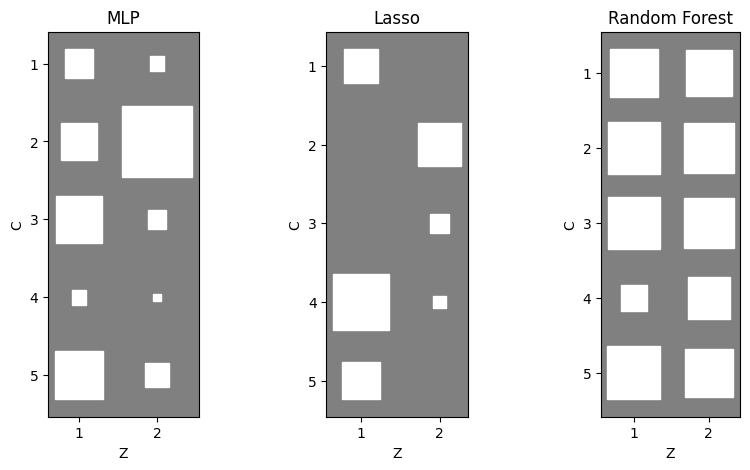

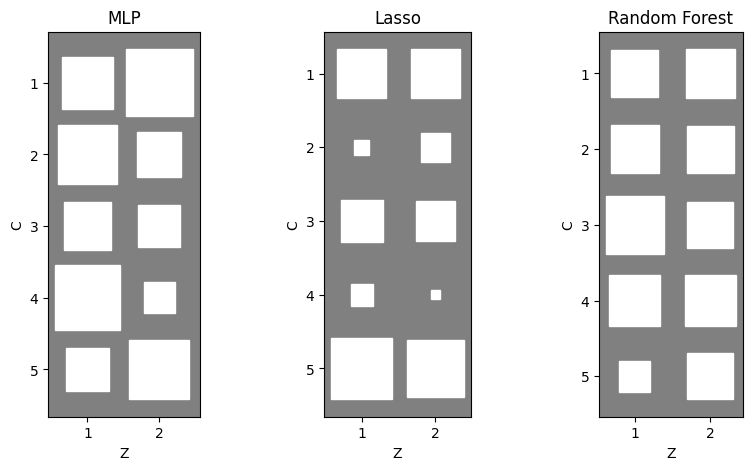

In [311]:
from disentangelement import *
codes_vae, Cs_vae, Ds_vae = get_important_latents(Rs_vae)
codes_vq, Cs_vq, Ds_vq = get_important_latents(Rs_vq)

In [293]:
from IPython.display import display, Latex
for i, C in enumerate(Ds_vq[0]):
    display(Latex(f'$C_{i+1}: {C:.3f}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [279]:
from IPython.display import display, Latex
E = np.array(loss).mean()
mlp="mlp"
display(Latex(f'$E= {E:.3f}$'))

<IPython.core.display.Latex object>

In [237]:
def plot_parameter_scatter(labels, prediction_lin, prediction_f):
    n_features = labels.shape[1]
    x_axis = np.arange(len(labels))
    
    blue_handle = plt.Line2D([], [], color='b', label='Original Data', alpha=0.2)
    red_handle = plt.Line2D([], [], color='r', label='Reconstructions mean')
    titles = ["mean", "Std", "Freaquency per Week", "Amplitude", "Phase"]

    fig, ax = plt.subplots(nrows=n_features, ncols=2,figsize=(20, 16))
    for i in range(n_features):    
        ax[0, i].scatter(x_axis, labels[:, i], c="b", alpha = 0.5)
        ax[0, i].scatter(x_axis, prediction_lin[:, i], c="r" , alpha = 0.2)
        ax[0, i].set_title(titles[i])
        ax[0, i].legend(handles=[blue_handle, red_handle], loc="upper right")
        
        ax[1, i].scatter(x_axis, labels[:, i], c="b", alpha = 0.5)
        ax[1, i].scatter(x_axis, prediction_f[:, i], c="r" , alpha = 0.2)
        ax[1, i].set_title(titles[i])
        ax[1, i].legend(handles=[blue_handle, red_handle], loc="upper right")
        set_y_lim(ax[i, 0], i)
        set_y_lim(ax[i, 1], i)
    fig.tight_layout()

In [166]:
latents = indices.view(z.shape[0], -1)
latents.shape

torch.Size([4000, 5])

In [215]:
codes_vae

array([[1., 1.],
       [1., 0.],
       [4., 4.]])

In [216]:
def plot_latents_vs_labels(latents, labels, codes):
    fig, axs = plt.subplots(codes.shape[1], codes.shape[0], figsize=(12, 10))
    titles = ["MLP", "Lasso", "Random Forest"]
    for i, code in enumerate(codes.T):
        for j in range(len(code)):
            lat1, lat2, lat3 = [int(c) for c in code]
            axs[i,j].scatter(latents[:,int(code[j])], labels[:,i])
            axs[i,j].set_xlabel("latent {}".format(code[j]))
            axs[i,j].set_ylabel("z {}".format(i))
            axs[i,j].set_title(titles[j])

#             axs[i,1].scatter(latents[:,lat2], lab'els[:,i])
#             axs[i,1].set_xlabel("latent {}".format(c2))
#             axs[i,1].set_ylabel("z {}".format(i))
#             axs[i,0].set_title(titles[i])

#             axs[i,2].scatter(latents[:,lat3], labels[:,i])
#             axs[i,2].set_xlabel("latent {}".format(c2))
#             axs[i,2].set_ylabel("z {}".format(i))
#             axs[i,0].set_title(titles[i])'
    
    

ValueError: not enough values to unpack (expected 3, got 2)

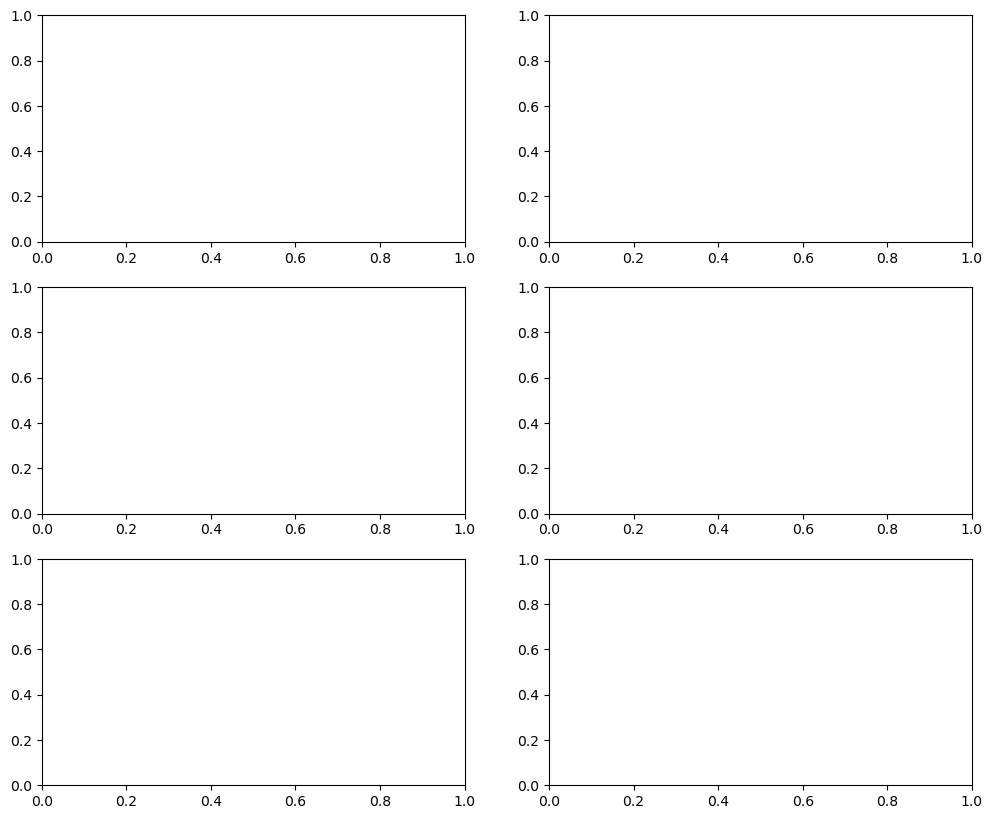

In [218]:
plot_latents_vs_labels(latents, y_train_vq, codes_vae)

/tmp/ipykernel_101/1324765137.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca[:, 0], X_pca[:, 1], cmap='viridis')


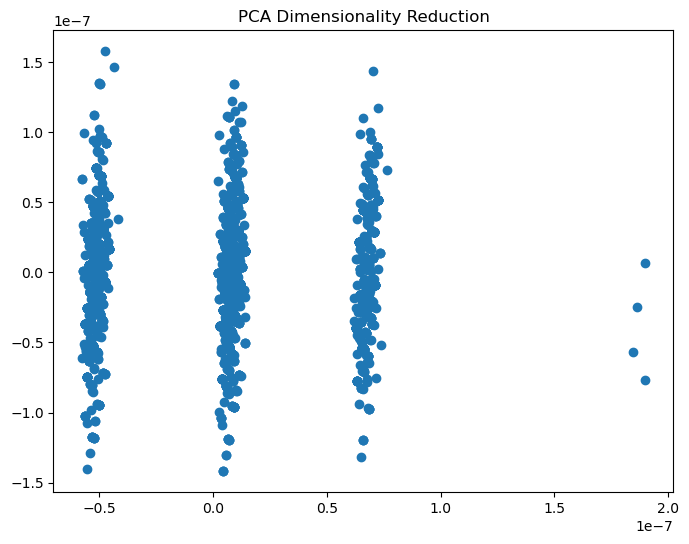

In [170]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(latents)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], cmap='viridis')
plt.title('PCA Dimensionality Reduction')
plt.show()

/tmp/ipykernel_101/2185305320.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_embedded[:, 0], X_embedded[:, 1], cmap='viridis')


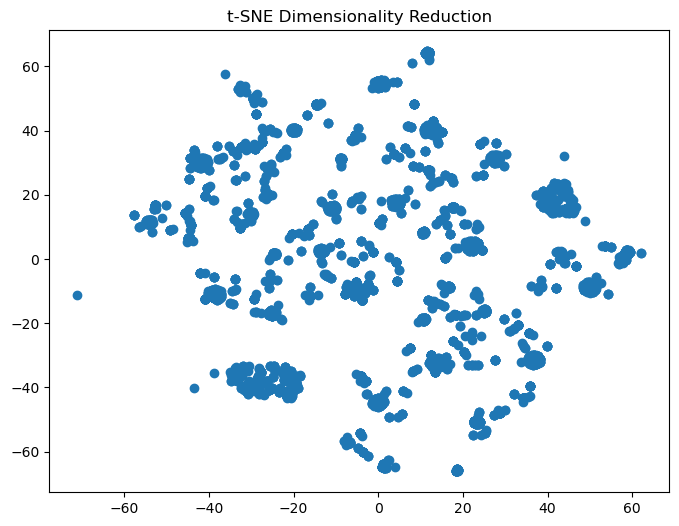

In [173]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(latents)

# Plot the reduced-dimensional data
plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], cmap='viridis')
plt.title('t-SNE Dimensionality Reduction')
plt.show()

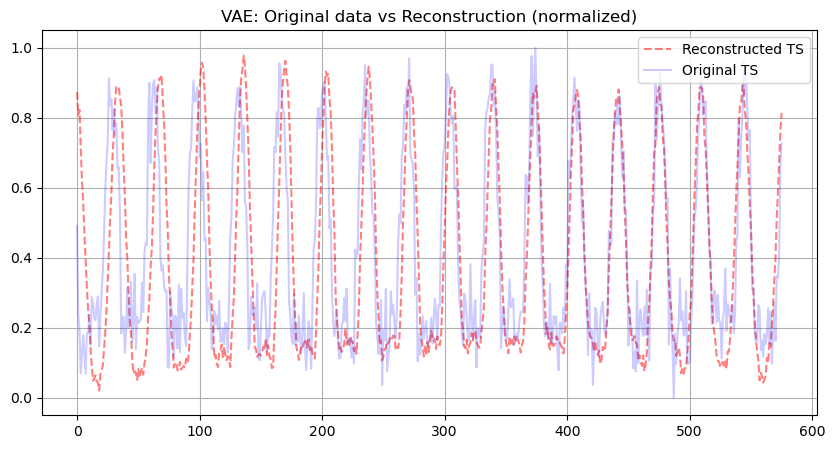

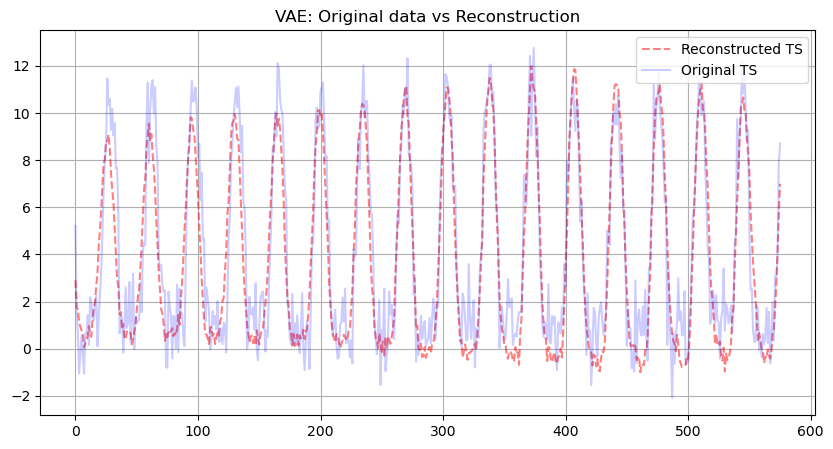

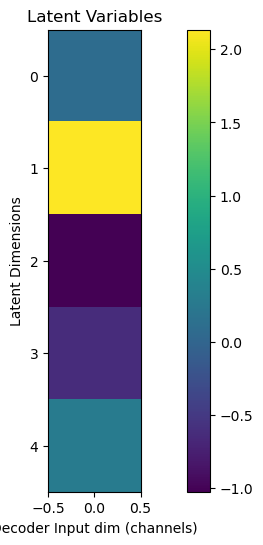

/home/anis/mambaforge/envs/tenv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


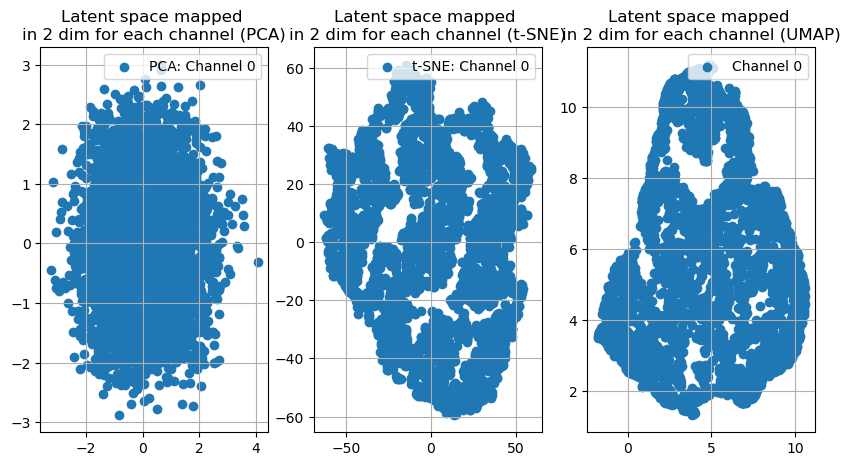

ValueError: n_components=2 must be between 0 and min(n_samples, n_features)=1 with svd_solver='full'

In [219]:
show_results(vae, train_data, args, plot_latent=True)